<a href="https://colab.research.google.com/github/ulissesmaffa/tcc/blob/main/Trabalho_de_Conclus%C3%A3o_de_Curso_Ulisses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trabalho de Conclusão de Curso 2023/2

* Universidade Estadual do Rio Grande do Sul
* Unidade em Guaíba
* Curso de Engenharia de Computação
* Aluno:Ulisses Maffazioli

**Arquitetura de condicionador digital para sensores de natureza resistiva**

Acesso github de todos os códigos utilizados no TCC: https://github.com/ulissesmaffa/tcc.git

# Configuração do Ambiente

In [12]:
!pip3 install control

In [13]:
import control
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from  matplotlib import patches
from matplotlib.figure import Figure
from matplotlib import rcParams
import scipy.io.wavfile
from IPython.display import Audio
from scipy.fft import fft, fftfreq
import math
from scipy.signal import find_peaks
from scipy.signal import square

# Amostragem


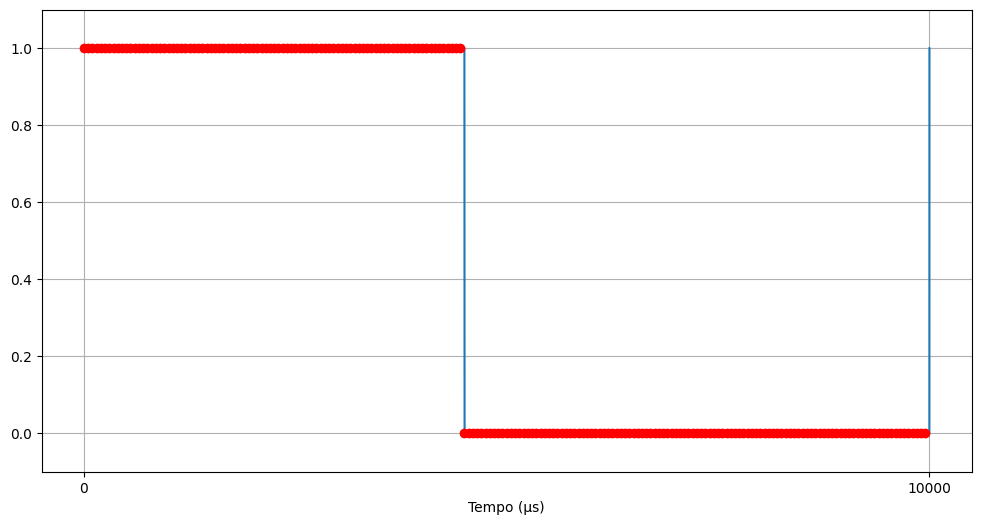

Período: 1
Quantidade de pontos em 1: 90
Quantidade de pontos em 0: 110
Quantidade de pontos total: 200
Tempo em 1: 4500
Tempo em 0: 5500
Tempo total: 10000
Frequência: 100.0Hz



In [8]:
f = 100  # frequência da onda em Hz
T = 1/f  # período em segundos
T_us = T * 1e6  # período em microsegundos
duty_cycle = 0.45  # ciclo de trabalho
n_periods = 1  # número de períodos para visualizar
n_points_per_period = 10000  # número de pontos por período
t = np.linspace(0, n_periods / f, n_periods * n_points_per_period)  # vetor de tempo
signal = 0.5 * (1 + square(2 * np.pi * f * t, duty=duty_cycle))  # onda quadrada

#inicio da amostragem =================================================================================
t_amostragem = 50 #período de amostragem em microsegundos
sample_rate = 1/t_amostragem*10**6  # taxa de amostragem em Hz
sample_times = np.arange(0, t[-1], 1/sample_rate)  # momentos de amostragem

# obtenha os valores do sinal nesses momentos, arredonde para o inteiro mais próximo para obter 0 ou 1
sample_values = np.round(np.interp(sample_times, t, signal))
T = 1/f  # período em segundos
T_us = T * 1e6  # período em microssegundos
plt.figure(figsize=(12, 6))
plt.plot(t * 1e6, signal)  # converte o tempo para microssegundos
# Adiciona os pontos de amostragem
plt.plot(sample_times * 1e6, sample_values, 'ro')  # 'ro' faz com que os pontos sejam plotados como círculos vermelhos
plt.ylim(-0.1, 1.1)
# Coloca marcas no eixo x a cada período
xticks = np.arange(0, (n_periods+1) * T_us, T_us)
plt.xticks(xticks)
plt.grid(True)
plt.xlabel("Tempo (µs)")  # adiciona uma etiqueta ao eixo x
plt.show()
#fim da amostragem =================================================================================


# quantidade de períodos que se quer analisar
num_periods_to_analyse = n_periods
# pontos de amostragem por período
samples_per_period = int(sample_rate / f)
for i in range(num_periods_to_analyse):
    # seleciona os pontos de amostra para o período atual
    samples_this_period = sample_values[i * samples_per_period:(i + 1) * samples_per_period]

    # conta a quantidade de pontos que são 1 e 0
    count_1 = np.sum(samples_this_period == 1)
    count_0 = np.sum(samples_this_period == 0)

    print(f"Período: {i+1}")
    print(f"Quantidade de pontos em 1: {count_1}")
    print(f"Quantidade de pontos em 0: {count_0}")
    print(f"Quantidade de pontos total: {count_0+count_1}")
    print(f"Tempo em 1: {count_1*t_amostragem}")
    print(f"Tempo em 0: {count_0*t_amostragem}")
    print(f"Tempo total: {(count_1*t_amostragem)+count_0*t_amostragem}")
    periodo_de_amostragem=((count_1*t_amostragem)+count_0*t_amostragem)
    print(f"Frequência: {(1/periodo_de_amostragem)*10**6}Hz\n")


# Caracterização dos Sensores NTC
Capítulo 3.2

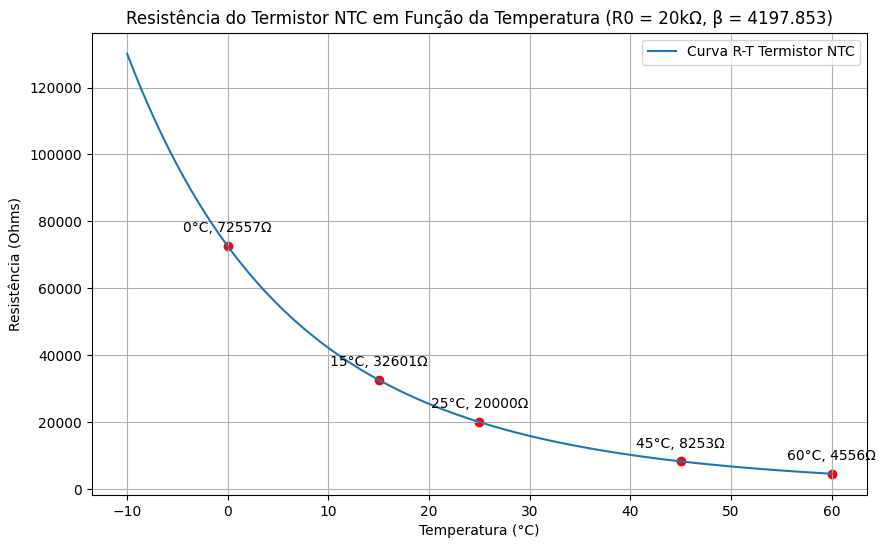

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Definindo o valor de Beta e R0
beta = 4197.853  # Coeficiente Beta
R0 = 20000   # Resistência a 25°C em Ohms (20kΩ)
T0 = 298.15  # Temperatura de referência em Kelvin (25°C)

# Criando um intervalo de temperaturas em Kelvin
temperaturas_C = np.linspace(-10, 60, 100)
temperaturas_K = temperaturas_C + 273.15

# Calculando a resistência para cada temperatura usando a equação do termistor NTC
resistencias = R0 * np.exp(beta * (1/temperaturas_K - 1/T0))

# Plotando o gráfico
plt.figure(figsize=(10, 6))
plt.plot(temperaturas_C, resistencias, label='Curva R-T Termistor NTC')
plt.title('Resistência do Termistor NTC em Função da Temperatura (R0 = 20kΩ, β = 4197.853)')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Resistência (Ohms)')
plt.grid(True)

# Temperaturas específicas para anotar
temperaturas_especificas = [0, 15, 25, 45, 60]

# Calculando e anotando as resistências correspondentes a estas temperaturas
for temp in temperaturas_especificas:
    T = temp + 273.15  # Convertendo para Kelvin
    R = R0 * np.exp(beta * (1/T - 1/T0))
    plt.scatter(temp, R, color='red')  # Ponto no gráfico
    plt.annotate(f'{temp}°C, {R:.0f}Ω', (temp, R), textcoords="offset points", xytext=(0,10), ha='center')

plt.legend()
plt.show()

# Implementação do Circuito Oscilador com CI 555
Capítulo 3.3

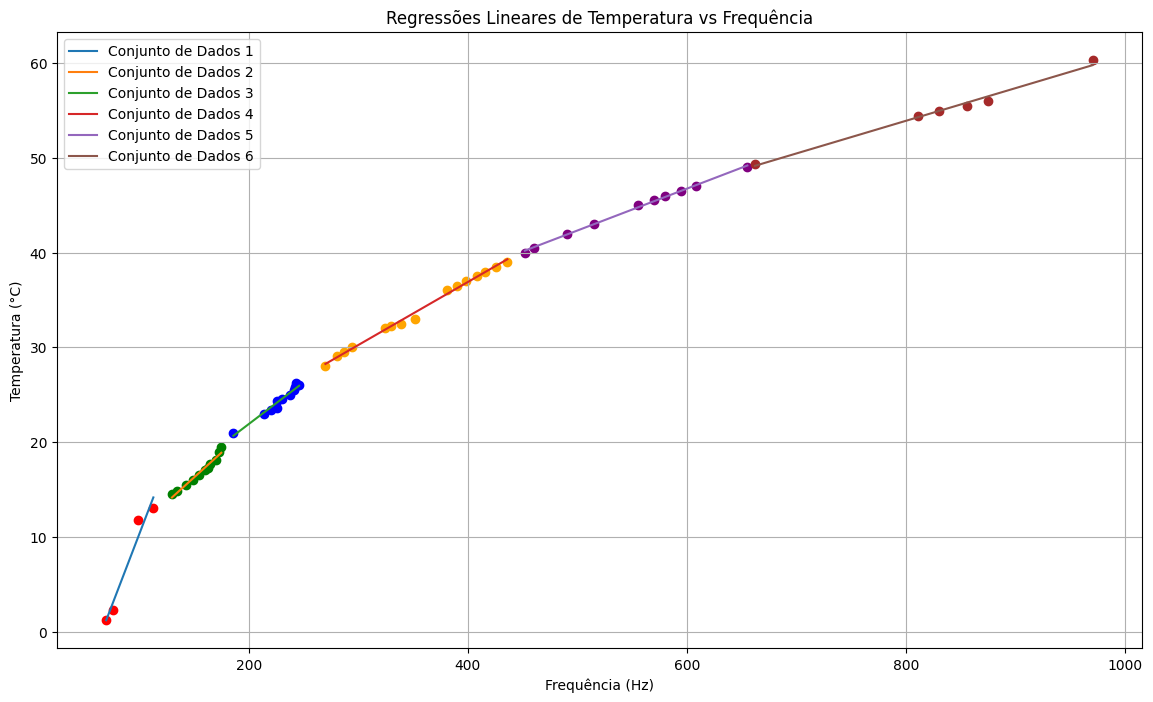

In [10]:
# Criando um único gráfico com todas as regressões lineares dos conjuntos de dados
plt.figure(figsize=(14, 8))

# Cores para os gráficos
cores = ['red', 'green', 'blue', 'orange', 'purple', 'brown']

# Conjuntos de dados
conjuntos_de_dados = {
    'Conjunto de Dados 1': ([70, 76, 99, 113], [1.2, 2.3, 11.8, 13]),
    'Conjunto de Dados 2': ([130, 135, 143, 149, 155, 160, 163, 165, 170, 173, 175],
                             [14.5, 14.8, 15.5, 16, 16.5, 17, 17.3, 17.7, 18.1, 19, 19.5]),
    'Conjunto de Dados 3': ([186, 214, 220, 226, 226, 230, 238, 241, 242, 243, 246],
                             [21, 23, 23.4, 23.6, 24.3, 24.5, 25, 25.5, 25.8, 26.2, 26]),
    'Conjunto de Dados 4': ([270, 281, 287, 294, 324, 330, 339, 352, 381, 390, 398, 408, 416, 426, 436],
                             [28, 29.1, 29.5, 30, 32, 32.3, 32.5, 33, 36.1, 36.5, 37, 37.5, 38, 38.5, 39]),
    'Conjunto de Dados 5': ([452, 460, 490, 515, 555, 570, 580, 594, 608, 655],
                             [40, 40.5, 42, 43, 45, 45.5, 46, 46.5, 47, 49]),
    'Conjunto de Dados 6': ([662, 811, 830, 855, 875, 970],
                             [49.4, 54.4, 54.9, 55.5, 56, 60.3]),
}

# Plotando cada conjunto de dados e sua respectiva regressão linear
for titulo, (freq, temp) in conjuntos_de_dados.items():
    coeficientes = np.polyfit(freq, temp, 1)
    equacao = np.poly1d(coeficientes)
    y_pred = equacao(freq)

    plt.scatter(freq, temp, color=cores.pop(0))  # Dados
    plt.plot(freq, y_pred, label=titulo)  # Linha de regressão

# Formatação do gráfico
plt.title('Regressões Lineares de Temperatura vs Frequência')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Conjunto de dados 1
Temp1 = [1.2, 2.3, 11.8, 13]
Freq1 = [70, 76, 99, 113]

# Conjunto de dados 2
Temp2 = [14.5, 14.8, 15.5, 16, 16.5, 17, 17.3, 17.7, 18.1, 19, 19.5]
Freq2 = [130, 135, 143, 149, 155, 160, 163, 165, 170, 173, 175]

# Conjunto de dados 3
Temp3 = [21, 23, 23.4, 23.6, 24.3, 24.5, 25, 25.5, 25.8, 26.2, 26]
Freq3 = [186, 214, 220, 226, 226, 230, 238, 241, 242, 243, 246]

# Conjunto de dados 4
Temp4 = [28, 29.1, 29.5, 30, 32, 32.3, 32.5, 33, 36.1, 36.5, 37, 37.5, 38, 38.5, 39]
Freq4 = [270, 281, 287, 294, 324, 330, 339, 352, 381, 390, 398, 408, 416, 426, 436]

# Conjunto de dados 5
Temp5 = [40, 40.5, 42, 43, 45, 45.5, 46, 46.5, 47, 49]
Freq5 = [452, 460, 490, 515, 555, 570, 580, 594, 608, 655]

# Conjunto de dados 6
Temp6 = [49.4, 54.4, 54.9, 55.5, 56, 60.3]
Freq6 = [662, 811, 830, 855, 875, 970]


In [16]:
import numpy as np
import matplotlib.pyplot as plt

def regressao_linear_e_plot(x, y, titulo):
    coeficientes = np.polyfit(x, y, 1)
    equacao = np.poly1d(coeficientes)
    y_pred = equacao(x)
    # rmse = np.sqrt(mean_squared_error(y, y_pred))
    print(titulo)
    print('Equação da reta: Temperatura = {:.2f} * Frequência + {:.2f}'.format(coeficientes[0], coeficientes[1]))
    # print('RMSE: {:.2f}'.format(rmse))
    print('\n')
    # plt.scatter(x, y, label='Dados')
    # plt.plot(x, y_pred, label='Regressão Linear', color='red')
    # plt.title(titulo)
    # plt.xlabel('Freq')
    # plt.ylabel('Temp')
    # plt.legend()
    # plt.show()

regressao_linear_e_plot(Freq1, Temp1, 'Conjunto de Dados 1')

regressao_linear_e_plot(Freq2, Temp2, 'Conjunto de Dados 2')

regressao_linear_e_plot(Freq3, Temp3, 'Conjunto de Dados 3')

regressao_linear_e_plot(Freq4, Temp4, 'Conjunto de Dados 4')

regressao_linear_e_plot(Freq5, Temp5, 'Conjunto de Dados 5')

regressao_linear_e_plot(Freq6, Temp6, 'Conjunto de Dados 6')

Conjunto de Dados 1
Equação da reta: Temperatura = 0.30 * Frequência + -19.90


Conjunto de Dados 2
Equação da reta: Temperatura = 0.10 * Frequência + 0.55


Conjunto de Dados 3
Equação da reta: Temperatura = 0.09 * Frequência + 4.31


Conjunto de Dados 4
Equação da reta: Temperatura = 0.07 * Frequência + 10.28


Conjunto de Dados 5
Equação da reta: Temperatura = 0.04 * Frequência + 20.21


Conjunto de Dados 6
Equação da reta: Temperatura = 0.03 * Frequência + 26.33


